# Evaluating new fasttext model(s) for OSCAR

In [3]:
from glob import glob
import pandas as pd
import fasttext
from pathlib import Path
import langcodes
import timeit


In [4]:

old = fasttext.load_model("lid.176.bin")
new = fasttext.load_model("lid.189.bin")
times_old = list()
times_new = list()

to_concat = list()
ignored = list()
for idx, f in enumerate(glob("res/formatted/*.json")):
    df = pd.read_json(f, lines=True)
    lang = Path(f).stem
    if lang == "size":
        continue
    try:
        df = pd.DataFrame(df["records"][0])
        df = df.iloc[:, :4]
        df.columns = ["offensive", "porn", "code", "content"]
        df["lang"] = lang
    except ValueError:
        ignored.append(f)
    # df = pd.DataFrame(df["records"][0], columns=df["headers"])
    # df["old_id"] = lang
    to_concat.append(df)
result = pd.concat(to_concat)
#     for l in df["records"][0]:
#         try:
#             sentence = l[3].replace("\n", "")
#             starttime = timeit.default_timer()
#             old.predict(sentence)
#             endtime = timeit.default_timer() - starttime
#             times_old.append(endtime)
#             starttime = timeit.default_timer()
#             new.predict(sentence)
#             endtime = timeit.default_timer() - starttime
#             times_new.append(endtime)
#         except IndexError:
#             pass
# times_old = pd.Series(times_old)
# times_new = pd.Series(times_new)

# result = pd.concat(to_concat)
# print(result[:4])
# result.columns = ["offensive", "porn", "code", "content"]
print(f"ignored {ignored}")

ignored []


In [5]:
#remove empty lines
result = result[result["content"] != ""]
result = result[~result["content"].isnull()]

## Benchmark fasttext

In [6]:

old = fasttext.load_model("lid.176.bin")
new = fasttext.load_model("lid.189.bin")
times_old = list()
times_new = list()

for sentence_group in result["content"]:
    sentences = sentence_group.splitlines()
    for s in sentences:
        #pred old
        start = timeit.default_timer()
        old.predict(s)
        duration = timeit.default_timer() - start
        times_old.append(duration)

        #pred new
        start = timeit.default_timer()
        new.predict(s)
        duration = timeit.default_timer() - start
        times_new.append(duration) 

times_old = pd.Series(times_old)
times_new = pd.Series(times_new)

print(f"lid.176.bin mean: {times_old.mean()}, std: {times_old.std()} ({len(times_old)} samples)")
print(f"lid.189.bin mean: {times_new.mean()}, std: {times_new.std()} ({len(times_old)} samples)")


lid.176.bin mean: 5.3784568160752216e-05, std: 3.521947965336406e-05 (26284 samples)
lid.189.bin mean: 0.00019715507218997323, std: 0.00010236379365572593 (26284 samples)


## Add ids

We add ids on each sentence.
It's not perfect, since some rows have multiple sentences. We merge sentences in that case.

In [7]:
# re-running id
result["old_id"] = result["content"].apply(lambda x: old.predict(x.replace("\n", "")))
result["new_id"] = result["content"].apply(lambda x: new.predict(x.replace("\n", "")))

In [8]:

# moving from a column of ((id1, id2, ...), [prob1, prob2]) to two cols id1 and prob1
result[["old_id_label", "old_id_prob"]] = pd.DataFrame(result['old_id'].tolist(), index=result.index) 
result["old_id_label"] = result["old_id_label"].apply(lambda x: x[0][9:])
result["old_id_prob"] = result["old_id_prob"].apply(lambda x: x[0])
#del result["old_id"]


# moving from a column of ((id1, id2, ...), [prob1, prob2]) to two cols id1 and prob1
result[["new_id_label", "new_id_prob"]] = pd.DataFrame(result['new_id'].tolist(), index=result.index) 
# converting to tags comparable to old ones
result["new_id_label"] = result["new_id_label"].apply(lambda x: langcodes.get(x[0][9:]).to_tag())
#result[result["new_id_label"] == "swh"] = "sw"
result["new_id_prob"] = result["new_id_prob"].apply(lambda x: x[0])
#del result["new_id"]

In [9]:
# map all new ids with prob < 0.8 to a "None" prediction
fails = result["new_id_prob"] < 0.8
result.loc[fails,"new_id_thresh"] = None
succ = result["new_id_prob"] > 0.8
result.loc[succ, "new_id_thresh"] = result.loc[succ, "new_id_label"]

In [10]:
# get old->new only
ids = result[["lang", "new_id_thresh"]]
ids.columns = ["actual", "predicted"]

# fix swahili
swh = ids["predicted"] == "swh"
ids.loc[swh, "predicted"] = "sw"

ids_conf = pd.crosstab(ids["actual"], ids["predicted"])

ids_conf["sw"]["sw"] = 100
print(list(ids_conf["sw"]))
print(ids_conf.apply(lambda x: (x != 0).sum(), axis=0)["sw"])
# get confusion on langs that were at least a bit misclassified
# (= where confusion matrix is !=0 for at least two values)
ids_conf_relevant = ids_conf.apply(lambda x: (x != 0).sum(), axis=1) > 1
ids_conf_relevant = ids_conf[ids_conf_relevant]
ids_conf_relevant

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1


/var/folders/7v/bf41r4r92hjdhkph2_hpfy9h00mb2w/T/ipykernel_94393/2743516526.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ids.loc[swh, "predicted"] = "sw"


predicted,af,am,ar,ast,azb,bg,bho,bs,bxr,ca,...,tt,tum,uk,uz,vec,vi,yo,yue,zh,zza
actual,,,,,,,,,,,,,,,,,,,,,
als,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
am,0,857,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
an,0,0,0,10,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
ast,0,0,0,1990,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bh,0,0,0,0,0,0,94,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bs,0,0,0,0,0,1,0,22,0,0,...,0,0,0,0,0,0,0,0,0,0
ca,0,0,0,0,0,0,0,0,0,99,...,0,0,0,0,0,0,0,0,0,0
da,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


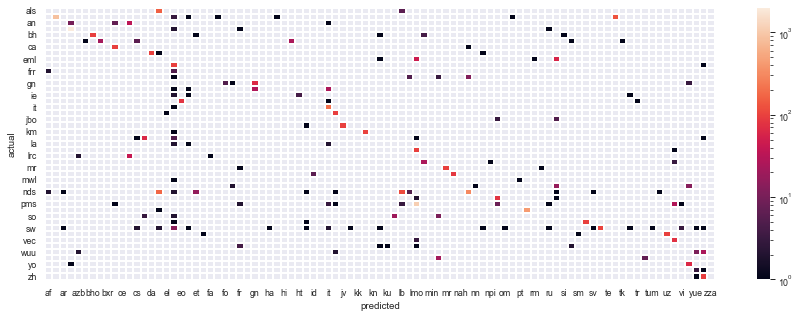

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 5))
sns.set_context("paper")
sns.set_style("darkgrid")
sns.heatmap(ids_conf_relevant, linewidth=0.1, norm=LogNorm())
plt.show()


In [12]:
plt.figure(figsize=(10, 20))
plt.show()

<Figure size 720x1440 with 0 Axes>

apply same fixes from `pipline.py`

Remember: We have data from oscar only here, so counts will vary vs. pipline


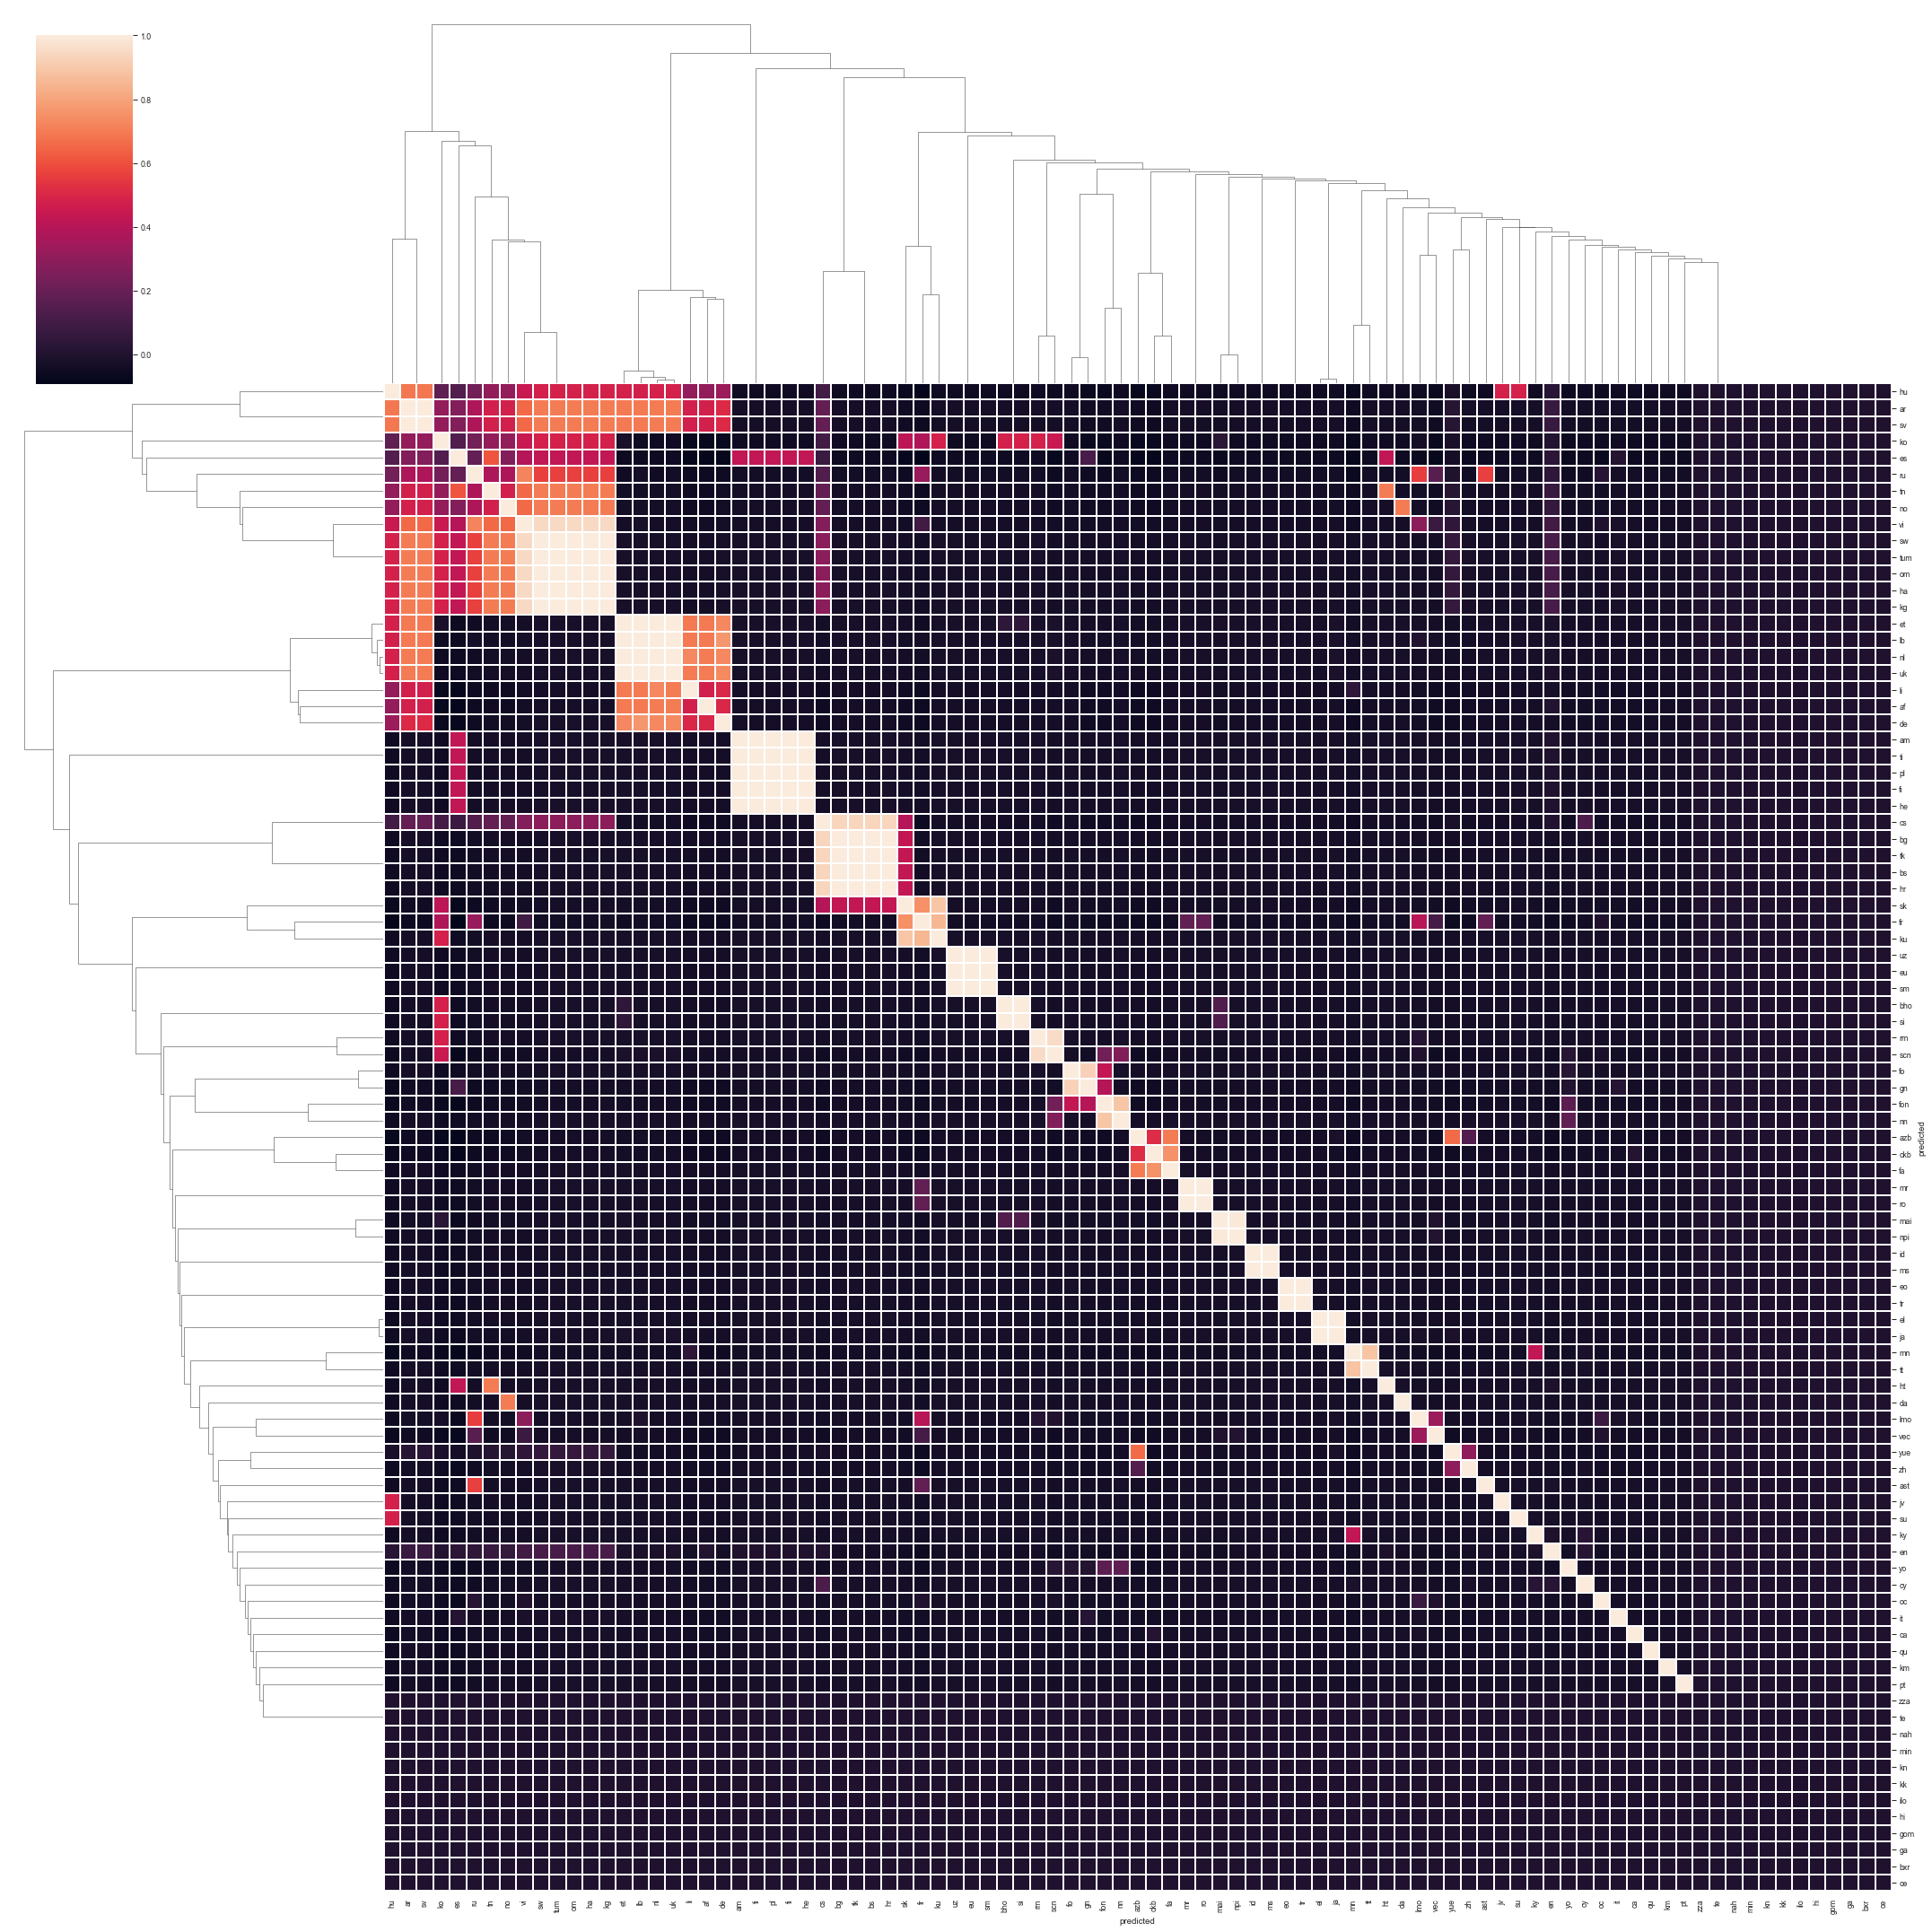

In [42]:
ids_edited = ids_conf_relevant.copy()
ids_edited = ids_edited.loc[~(ids_edited == 0).all(axis=1)]
ids_edited
#del ids_edited["zza"]
#del ids_edited["bxr"]
#del ids_edited["ce"]
ids_edited_corr = ids_edited.corr()
#ids_edited_corr = ids_edited_corr.loc[~(ids_edited_corr.isna()).all(axis=1)]
ids_edited_corr
sns.clustermap(ids_conf_relevant.corr().fillna(0), figsize=(30,30), linewidth=0.01)